### Training the ResNet-50 out-of-box model with CSISS labeled data only

#### Imports

In [12]:
import torch
import torchvision
import os
import torchvision.transforms as transforms 
import numpy as np
import pandas as pd
import time
import torch.optim as optim
import torch.nn as nn

from datetime import datetime
import matplotlib.pyplot as plt
import urllib.parse as urlparse
from rasterio.io import MemoryFile
from pathlib import Path
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
from PIL import Image

In [2]:
torch.manual_seed(42)

In [3]:
print("PyTorch version: {}".format(torch.__version__))
print("Cuda version : {}".format(torch.version.cuda))
print('CUDNN version:', torch.backends.cudnn.version())
print('Number of available GPU Devices:', torch.cuda.device_count())
print("current GPU Device: {}".format(torch.cuda.current_device()))

PyTorch version: 1.13.1+cu117
Cuda version : 11.7
CUDNN version: 8500
Number of available GPU Devices: 1
current GPU Device: 0


In [4]:
config = {
    # Loader
    "train_csv": "/home/hanxli/data/data/all_training_svs_3class/train_split_esa_csiss.csv",
    "val_csv": "/home/hanxli/data/data/all_validation_svs_3class/val_split_esa_csiss.csv", 
    # Augmentation
    "train_mean" : [0.50614358, 0.57798129, 0.53686056],
    "train_stds" : [0.1789791, 0.20435749, 0.27934631],
    "val_mean" : [0.49846566, 0.57426037, 0.53141111],
    "val_stds" : [0.17893861, 0.20375895, 0.28002261],
    # Training
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "gpus": [0]
}

In [5]:
#### Augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.RandomRotation(degrees=(-90, 90)),
    transforms.RandomResizedCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = config["train_mean"], std = config["train_stds"])
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = config["val_mean"], std = config["val_stds"])
])
#### CustomDataset
class RoadSideCropDataset(Dataset):
    def __init__(self, data_csv, transform=None):
        self.lbl_csv = pd.read_csv(data_csv)
        self.transform = transform
        self.lbl_index = {
            "Other": 0,
            "Maize": 1,
            "Soybean": 2
        }

    def __len__(self):
        return len(self.lbl_csv)
    
    def __getitem__(self, idx):
        lbl = self.lbl_csv.loc[idx, "crop_type"]
        img_path = self.lbl_csv.loc[idx, "save_path"]
        img = Image.open(img_path).convert('RGB')
        lbl = self.lbl_index[str(lbl)]

        if self.transform:
            img = self.transform(img)
        return img, lbl
#### Dataloader
train_dataset = RoadSideCropDataset(config["train_csv"], transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = RoadSideCropDataset(config["val_csv"], transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
#### Utils
#### Train and Val functions
def train(trainData, model, criterion, optimizer, trainLoss, writer, gpu=True):
    """
    Train model
    Params:
        trainData (''DataLoader''): Batch grouped data
        model: Model to train
        criterion: Function to caculate loss
        oprimizer: Funtion for optimzation
        trainLoss: (empty list) To record average loss for each epoch
        gpu: (binary,optional) Decide whether to use GPU, default is True
    """

    model.train()


    epoch_loss = 0
    i = 0

    for img, label in trainData:


        img = Variable(img)
        label = Variable(label)
        if gpu:
            img = img.cuda()
            label = label.cuda()

        out = model(img)

        loss = criterion(out, label)
        epoch_loss += loss.item()
        i += 1


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f'train loss:{epoch_loss / i}')

    writer.add_scalar('Loss/Train', float(epoch_loss / i), i + 1)
    
    if trainLoss != None:
        trainLoss.append(float(epoch_loss / i))
def validate(valData, model, criterion, valLoss, writer,gpu=True):
    """
        Validate model
        Params:
            valData (''DataLoader''): Batch grouped data
            model: Trained model for validation
            criterion: Function to calculate loss
            valLoss (empty list): To record average loss for each epoch
            gpu (binary,optional): Decide whether to use GPU, default is True
    """

    model.eval()

    # mini batch iteration
    epoch_loss = 0
    i = 0
    correct = 0
    total = 0

    for img, label in valData:

        img = Variable(img, requires_grad=False)
        label = Variable(label, requires_grad=False)

        # GPU setting
        if gpu:
            img = img.cuda()
            label = label.cuda()

        out = model(img)

        loss = criterion(out, label)
        epoch_loss += loss.item()
        i += 1
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    val_accuracy = correct / total

    print('validation loss: {}'.format(epoch_loss / i))
    writer.add_scalar('Loss/Validation', float(epoch_loss / i), i + 1)
    writer.add_scalar('Accuracy/Validation', val_accuracy, i + 1)

    if valLoss != None:
        valLoss.append(float(epoch_loss / i))
#### Eval and Predict Func
def evaluate(model, dataloader, gpu):
    """
    Evaluate the performance of a trained model on the validation dataset.
    
    Args:
        model: The trained PyTorch model.
        dataloader: DataLoader for the validation dataset.
        device: 'cuda' or 'cpu'.
        
    Returns:
        accuracy: Accuracy of the model on the validation dataset.
        confusion_mat: Confusion matrix of the model's predictions.
    """
    model.eval()  # Set model to evaluation mode
    correct_preds = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    # No need to calculate gradients during evaluation
    with torch.no_grad():
        for batch in dataloader:
            # Unpack the batch (images and labels)
            images, labels = batch
            if gpu:
                images = images.cuda()
                labels = labels.cuda()            
            # Forward pass: compute the model output (logits)
            outputs = model(images)
                        
            # Get predicted class (index of the max log-probability)
            _, preds = torch.max(outputs, 1)
            
            # Update correct predictions and total number of samples
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)
            
            # Store predictions and labels for confusion matrix calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss
    
    # Calculate accuracy
    accuracy = correct_preds / total_samples
    
    # Confusion matrix (optional)
    confusion_mat = confusion_matrix(all_labels, all_preds)

    return accuracy, confusion_mat

os.getcwd()
#### Compile Model
class ModelCompiler:
    """
    Compiler of specified model
    Args:
        model (''nn.Module''): pytorch model for classification
        optimizer ()
        gpuDevices (list): indices of gpu devices to use
        params_init (dict object): initial model parameters
        freeze_params (list): list of indices for parameters to keep frozen
    """

    def __init__(self, model, gpuDevices=[0], params_init=None, freeze_params=None):
        os.chdir("/home/hanxli/data/outputs")
        self.working_dir = os.getcwd()
        self.out_dir = "predictions"

        # model

        self.model = model

        self.model_name = self.model.__class__.__name__

        

        if params_init:
            self.load_params(params_init, freeze_params)



        # gpu
        self.gpu = torch.cuda.is_available()

        if self.gpu:
            print('----------GPU available----------')
            # GPU setting
            if gpuDevices:
                torch.cuda.set_device(gpuDevices[0])
                self.model = torch.nn.DataParallel(self.model, device_ids=gpuDevices)
            self.model = self.model.cuda()

        num_params = sum([p.numel() for p in self.model.parameters() if p.requires_grad])
        print("total number of trainable parameters: {:2.1f}M".format(num_params / 1000000))

        if params_init:
            print(f"---------- Pre-trained {self.model_name} model compiled successfully ----------")
        else:
            print(f"---------- {self.model_name} Model compiled successfully ----------")

    def load_params(self, dir_params, freeze_params):

        params_init = urlparse.urlparse(dir_params)

        inparams = torch.load(params_init.path)

        ## overwrite model entries with new parameters
        model_dict = self.model.state_dict()

        if "module" in list(inparams.keys())[0]:
            inparams_filter = {k[7:]: v.cpu() for k, v in inparams.items() if k[7:] in model_dict}

        else:
            inparams_filter = {k: v.cpu() for k, v in inparams.items() if k in model_dict}
        model_dict.update(inparams_filter)
        # load new state dict
        self.model.load_state_dict(model_dict)

        # free some layers
        if freeze_params != None:
            for i, p in enumerate(self.model.parameters()):
                if i in freeze_params:
                    p.requires_grad = False


    def fit(self, trainDataset, valDataset, epochs, lr_init,
            criterion, scheduler = True, **kwargs):
        
        self.model_dir = "{}/{}/{}_ep{}".format(self.working_dir, self.out_dir, self.model_name, epochs)
        
        if not os.path.exists(Path(self.working_dir) / self.out_dir / self.model_dir):
            os.makedirs(Path(self.working_dir) / self.out_dir / self.model_dir)
        
        self.checkpoint_dir = Path(self.working_dir) / self.out_dir / self.model_dir / "chkpt"
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)
        
        os.chdir(Path(self.working_dir) / self.out_dir / self.model_dir)
        
        print("-------------------------- Start training --------------------------")
        start = datetime.now()
        
        writer = SummaryWriter(log_dir=Path(self.working_dir) / "runs" / "resnet-50-e30")
        train_loss = []
        val_loss = []


        optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, self.model.parameters()), lr_init)
        

        if scheduler:
            step_size = kwargs.get("step_size", 10)
            gamma = kwargs.get("gamma", 0.5)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        else:
            scheduler = None

        iterable = range(epochs)

        for t in iterable:

            print(f"[{t+1}/{epochs}]")

            # start fitting
            start_epoch = datetime.now()
            train(trainDataset, self.model, criterion, optimizer, train_loss, writer,gpu=self.gpu)

            validate(valDataset, self.model, criterion, val_loss, writer, gpu=self.gpu)

            # Update the scheduler
            scheduler.step()
            print(f"LR: {scheduler.get_last_lr()}")

            # time spent on single iteration
            print('time:', (datetime.now() - start_epoch).seconds)

            writer.add_scalars(
                "Loss",
                {"train_loss": train_loss[t],
                 "val_loss": val_loss[t]},
                 t + 1)

            checkpoint_interval = 2 # e.g. save every 10 epochs
            if (t+1) % checkpoint_interval == 0:
                torch.save(
                    {
                        "epoch": t+1,
                        "state_dict": self.model.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "train_loss": train_loss,
                        "val_loss": val_loss
                    }, os.path.join(
                        self.checkpoint_dir,
                        f"{t+1}_checkpoint.pth.tar")
                )

        writer.close()
        print(f"-------------------------- Training finished in {(datetime.now() - start).seconds}s --------------------------")
        return train_loss, val_loss

    

    def evaluate(self, evalDataset):

        if not os.path.exists(Path(self.working_dir) / self.out_dir):
            os.makedirs(Path(self.working_dir) / self.out_dir)
        
        print('-------------------------- Start evaluation --------------------------')
        start = datetime.now()

        print(start)
        acc, conf_mat = evaluate(self.model, evalDataset, self.gpu)

        print(f"-------------------------- Evaluation finished in {(datetime.now() - start).seconds}s --------------------------")
        print(acc)
        
        cmd = ConfusionMatrixDisplay(conf_mat)
        cmd.plot()
        cmd.ax_.set(xlabel='Predict', ylabel='True')


    # def predict(self, image_array):

    #     print('-------------------------- Start prediction --------------------------')
    #     start = datetime.now()
        
    #     out = predict(image_array, self.model)

        
    #     print('-------------------------- Prediction finished in {}s --------------------------' \
    #           .format((datetime.now() - start).seconds))
    #     return out
    
    def save(self, name, object = "params"):
        
        if object == "params":
            torch.save(self.model.state_dict(), 
                       os.path.join(self.checkpoint_dir, "{}_final_state.pth".format(name)))
            
            print("--------------------- Model parameters is saved to disk ---------------------")
        
        elif object == "model":
            torch.save(self.model, 
                       os.path.join(self.checkpoint_dir, "{}_final_state.pth".format(name)))
        
        else:
            raise ValueError("Improper object type.")

#### Train Model

In [6]:
import torchvision.models as models
model = models.resnet50(weights=None)

In [7]:
model = ModelCompiler(
        model=model, 
        gpuDevices=config["gpus"], 
        params_init=None)

----------GPU available----------
total number of trainable parameters: 25.6M
---------- ResNet Model compiled successfully ----------


In [8]:
train_loss, val_loss = model.fit(
    trainDataset=train_loader,
    valDataset=val_loader,
    epochs=30,
    lr_init=0.1,
    criterion=nn.CrossEntropyLoss(),
    scheduler=True
)

-------------------------- Start training --------------------------
[1/30]
train loss:2.9946489937893754
validation loss: 1.0232612295519738
LR: [0.1]
time: 19
[2/30]
train loss:0.9756177803138634
validation loss: 0.8011929534730458
LR: [0.1]
time: 17
[3/30]
train loss:0.8785712614461973
validation loss: 1.2896417145218169
LR: [0.1]
time: 17
[4/30]
train loss:0.7741212868071222
validation loss: 0.7208786940290814
LR: [0.1]
time: 17
[5/30]
train loss:0.7412950191404912
validation loss: 0.7767325263647806
LR: [0.1]
time: 17
[6/30]
train loss:0.713333513442572
validation loss: 0.7156360539652052
LR: [0.1]
time: 16
[7/30]
train loss:0.7051617607667848
validation loss: 0.7300336949882054
LR: [0.1]
time: 16
[8/30]
train loss:0.708450070062241
validation loss: 0.6829628186921278
LR: [0.1]
time: 16
[9/30]
train loss:0.6822906860283443
validation loss: 1.1954387078682582
LR: [0.1]
time: 16
[10/30]
train loss:0.6604155793592528
validation loss: 3.2153708785772324
LR: [0.05]
time: 16
[11/30]
tra

In [9]:
import matplotlib.pyplot as plt
def plot_curve (train, valid):
  plt.plot(np.arange(0, len(train)), train, label = "Train Loss")
  plt.plot(np.arange(0, len(train)), valid, label = "Validation Loss")
  plt.legend()

#   plt.savefig(os.path.join(os.getcwd(), f"{name}.png"))

  return plt.show()

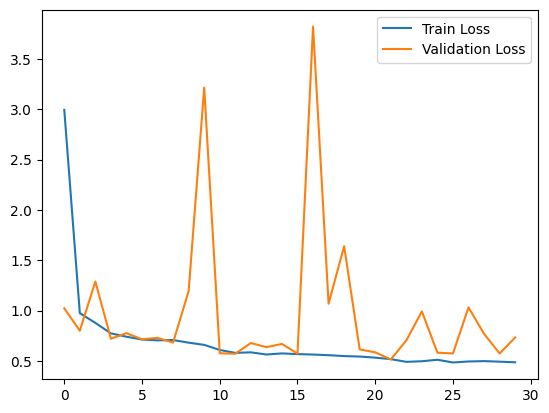

In [10]:
plot_curve(train_loss, val_loss)

-------------------------- Start evaluation --------------------------
2024-09-16 16:42:55.988645
-------------------------- Evaluation finished in 3s --------------------------
0.8054711246200608


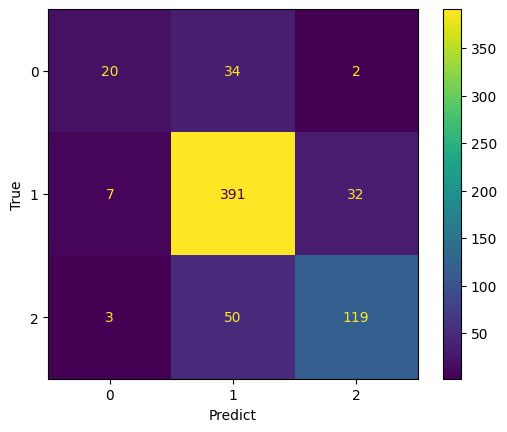

In [13]:
model.evaluate(val_loader)